In [1]:
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/MyDrive/MyProject

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/MyProject


In [2]:
import tensorflow as tf
tf.test.gpu_device_name()

''

In [3]:
!pip install opencv-python-headless
!pip install segmentation-models
!pip install -U segmentation-models
!pip install -U tensorflow==2.8.0

In [4]:
import os
import cv2
import numpy as np
import tensorflow as tf
from glob import glob
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.metrics import Metric
import tensorflow.keras.backend as K
import segmentation_models as sm
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from tqdm import tqdm
import pandas as pd
from tensorflow.keras.models import load_model

Segmentation Models: using `keras` framework.


In [5]:
# Setup
sm.set_framework('tf.keras')

In [6]:
BACKBONE = 'resnet34'
preprocess_input = sm.get_preprocessing(BACKBONE)

In [7]:
# Parameters
class_names = [
    'Background', 'Building-flooded', 'Building-non-flooded',
    'Road-flooded', 'Road-non-flooded', 'Water',
    'Tree', 'Vehicle', 'Pool', 'Grass'
]
N_CLASSES = len(class_names)
SIZE = 128
BATCH_SIZE = 8
EPOCHS = 14

In [8]:
# Paths to data
train_images_path = "FloodNet-Supervised_v1.0/train/train-org-img"
train_masks_path = "FloodNet-Supervised_v1.0/train/train-label-img"
val_images_path = "FloodNet-Supervised_v1.0/val/val-org-img"
val_masks_path = "FloodNet-Supervised_v1.0/val/val-label-img"
test_images_path = "FloodNet-Supervised_v1.0/test/test-org-img"
test_masks_path = "FloodNet-Supervised_v1.0/test/test-label-img"

In [9]:
# Function to load and preprocess dataset
def load_data(path, size, is_mask=False):
    images = []
    img_paths = sorted(glob(os.path.join(path, "*.jpg")) if not is_mask else glob(os.path.join(path, "*.png")))
    for img_path in tqdm(img_paths, desc="Loading images"):
        img = cv2.imread(img_path, cv2.IMREAD_COLOR if not is_mask else cv2.IMREAD_GRAYSCALE)
        img = cv2.resize(img, (size, size))
        if not is_mask:
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        images.append(img)
    images = np.array(images)
    if is_mask:
        images = np.expand_dims(images, axis=-1)
        return to_categorical(images, num_classes=N_CLASSES).reshape((-1, size, size, N_CLASSES))
    return images

In [10]:
# Load and preprocess datasets
train_images = preprocess_input(load_data(train_images_path, SIZE, is_mask=False))
train_masks = load_data(train_masks_path, SIZE, is_mask=True)

Loading images: 100%|██████████| 1445/1445 [01:46<00:00, 13.58it/s]


In [11]:
train_images.shape

(1445, 128, 128, 3)

In [12]:
train_masks.shape

(1445, 128, 128, 10)

In [13]:
val_images = preprocess_input(load_data(val_images_path, SIZE, is_mask=False))
val_masks = load_data(val_masks_path, SIZE, is_mask=True)

Loading images: 100%|██████████| 450/450 [00:29<00:00, 15.31it/s]


In [14]:
val_images.shape

(450, 128, 128, 3)

In [15]:
val_masks.shape

(450, 128, 128, 10)

In [16]:
test_images = preprocess_input(load_data(test_images_path, SIZE, is_mask=False))
test_masks = load_data(test_masks_path, SIZE, is_mask=True)

Loading images: 100%|██████████| 448/448 [00:28<00:00, 15.51it/s]


In [17]:
test_images.shape

(448, 128, 128, 3)

In [18]:
test_masks.shape

(448, 128, 128, 10)

In [19]:
class CustomMeanIoU(Metric):
    def __init__(self, num_classes, name='mean_iou', **kwargs):
        super(CustomMeanIoU, self).__init__(name=name, **kwargs)
        self.num_classes = num_classes
        self.total_iou = self.add_weight(name='total_iou', initializer='zeros')
        self.total_samples = self.add_weight(name='total_samples', initializer='zeros')

    def update_state(self, y_true, y_pred, sample_weight=None):
        y_pred = K.argmax(y_pred, axis=-1)
        y_true = K.argmax(y_true, axis=-1)
        y_pred = K.flatten(y_pred)
        y_true = K.flatten(y_true)
        for i in range(self.num_classes):
            true_positives = K.sum(K.cast((y_true == i) & (y_pred == i), K.floatx()))
            possible_positives = K.sum(K.cast(y_true == i, K.floatx()))
            predicted_positives = K.sum(K.cast(y_pred == i, K.floatx()))
            iou = true_positives / (possible_positives + predicted_positives - true_positives + K.epsilon())
            self.total_iou.assign_add(iou)
            self.total_samples.assign_add(1)

    def result(self):
        return self.total_iou / self.total_samples

    def reset_states(self):
        self.total_iou.assign(0.0)
        self.total_samples.assign(0.0)

In [20]:
# Define model
model = sm.Unet(BACKBONE, classes=N_CLASSES, activation='softmax', encoder_weights='imagenet')

85532672/85521592 [==============================] - 2s 0us/step


In [22]:
# Load model if exists to continue training
models_directory = 'Models'
model_files = [f for f in os.listdir(models_directory) if f.startswith('model_') and f.endswith('.h5')]
initial_epoch = 0
final_epoch = EPOCHS

In [25]:
if model_files:
    model_files.sort(key=lambda x: int(x.split('_')[1].split('.')[0]))
    latest_model_file = os.path.join(models_directory, model_files[-1])
    model = load_model(latest_model_file, compile=False, custom_objects={'CustomMeanIoU': CustomMeanIoU})
    print(f"Resuming from model: {latest_model_file}")

    log_file_path = os.path.join("Training/training_log.csv")
    if os.path.exists(log_file_path):
        training_log = pd.read_csv(log_file_path)
        if not training_log.empty:
            last_epoch = training_log['epoch'].max()
            initial_epoch = last_epoch + 1
            final_epoch = initial_epoch + EPOCHS
            print(f"Resuming training from epoch {initial_epoch} to {final_epoch}")
else:
    print("No previous model found, starting training from scratch.")

Resuming from model: Models/model_55.h5
Resuming training from epoch 57 to 70


In [26]:
# Callbacks for model training
callbacks = [
    tf.keras.callbacks.ModelCheckpoint("Models/model_{epoch:02d}.h5", save_best_only=True, verbose=1),
    tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=4, verbose=1),
    tf.keras.callbacks.CSVLogger(os.path.join("Training/training_log.csv"), append=True),
    tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, verbose=1)
]

In [27]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy', CustomMeanIoU(N_CLASSES)])

In [ ]:
# Train the model
history = model.fit(
    train_images, train_masks,
    batch_size=BATCH_SIZE,
    epochs=final_epoch,
    initial_epoch=initial_epoch,
    validation_data=(val_images, val_masks),
    callbacks=callbacks
)

Epoch 58/70
181/181 [==============================] - ETA: 0s - loss: 0.2559 - accuracy: 0.9131 - mean_iou: 0.5374

/usr/local/lib/python3.10/dist-packages/keras/engine/training.py:2034: UserWarning: Metric CustomMeanIoU implements a `reset_states()` method; rename it to `reset_state()` (without the final "s"). The name `reset_states()` has been deprecated to improve API consistency.
  m.reset_state()



Epoch 58: val_loss improved from inf to 0.42356, saving model to Models/model_58.h5
181/181 [==============================] - 546s 3s/step - loss: 0.2559 - accuracy: 0.9131 - mean_iou: 0.5374 - val_loss: 0.4236 - val_accuracy: 0.8727 - val_mean_iou: 0.3509 - lr: 0.0010
Epoch 59/70
181/181 [==============================] - ETA: 0s - loss: 0.2275 - accuracy: 0.9222 - mean_iou: 0.5532
Epoch 59: val_loss improved from 0.42356 to 0.40098, saving model to Models/model_59.h5
181/181 [==============================] - 544s 3s/step - loss: 0.2275 - accuracy: 0.9222 - mean_iou: 0.5532 - val_loss: 0.4010 - val_accuracy: 0.8786 - val_mean_iou: 0.3705 - lr: 0.0010
Epoch 60/70
181/181 [==============================] - ETA: 0s - loss: 0.2118 - accuracy: 0.9280 - mean_iou: 0.5778
Epoch 60: val_loss improved from 0.40098 to 0.39968, saving model to Models/model_60.h5
181/181 [==============================] - 543s 3s/step - loss: 0.2118 - accuracy: 0.9280 - mean_iou: 0.5778 - val_loss: 0.3997 - val

In [ ]:
# Evaluate the model on the test set
test_predictions = model.predict(test_images)
test_predictions_argmax = np.argmax(test_predictions, axis=-1)
test_masks_argmax = np.argmax(test_masks.reshape((-1, SIZE, SIZE, N_CLASSES)), axis=-1)

In [ ]:
# accuracy calculation
accuracy = np.mean(test_masks_argmax == test_predictions_argmax)
print(f"Test Accuracy: {accuracy:.4f}")

Test Accuracy: 0.8924


In [ ]:
# Calculate and print Mean IoU using the custom metric
iou_calculator = CustomMeanIoU(N_CLASSES)
iou_calculator.update_state(to_categorical(test_masks_argmax, num_classes=N_CLASSES), test_predictions)
mean_iou = iou_calculator.result().numpy()
print(f"Mean IoU: {mean_iou:.4f}")

Mean IoU: 0.6046


In [ ]:
def compute_per_class_iou(y_true, y_pred, num_classes):
    per_class_iou = []
    y_pred = tf.argmax(y_pred, axis=-1)
    y_true = tf.argmax(y_true, axis=-1)

    for i in range(num_classes):
        true_positive = tf.equal(y_true, i) & tf.equal(y_pred, i)
        false_positive = tf.not_equal(y_true, i) & tf.equal(y_pred, i)
        false_negative = tf.equal(y_true, i) & tf.not_equal(y_pred, i)

        intersection = tf.reduce_sum(tf.cast(true_positive, tf.float32))
        union = tf.reduce_sum(tf.cast(true_positive | false_positive | false_negative, tf.float32))

        iou = intersection / union if union != 0 else 0
        per_class_iou.append(iou)

    return per_class_iou

In [ ]:
# Compute IoU for each class
per_class_iou = compute_per_class_iou(test_masks, test_predictions, N_CLASSES)

# Print IoU for each class
for i, iou in enumerate(per_class_iou):
    print(f"IoU for {class_names[i]} is: {iou:.4f}")

IoU for Background is: 0.3681
IoU for Building-flooded is: 0.6742
IoU for Building-non-flooded is: 0.7111
IoU for Road-flooded is: 0.6069
IoU for Road-non-flooded is: 0.7786
IoU for Water is: 0.7593
IoU for Tree is: 0.7835
IoU for Vehicle is: 0.1894
IoU for Pool is: 0.3068
IoU for Grass is: 0.8677


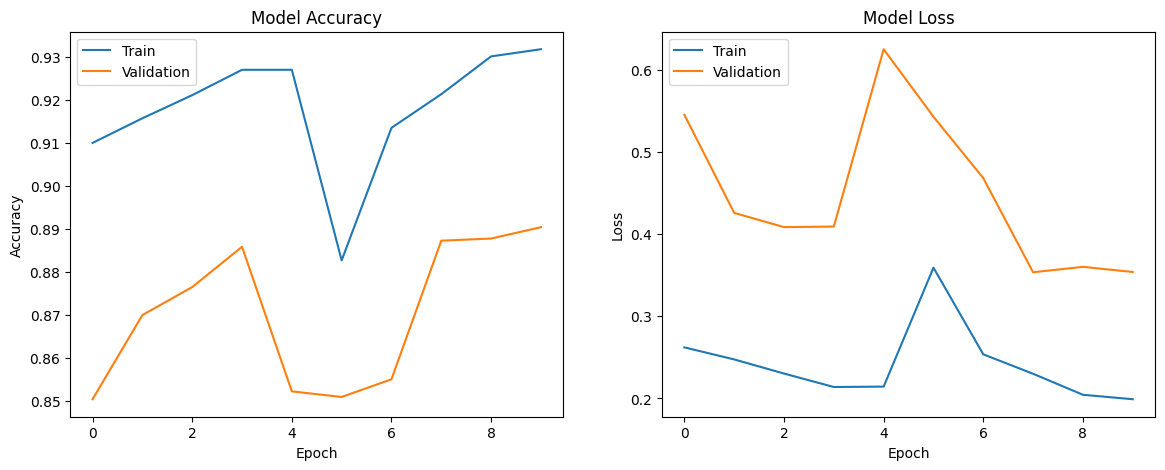

In [ ]:
# Plot training & validation accuracy and loss values
plt.figure(figsize=(14, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

<ipython-input-37-9fcd9f2f3ae9>:4: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('tab10', N_CLASSES)  # Ensure your N_CLASSES fits the 'tab10' or choose an appropriate colormap


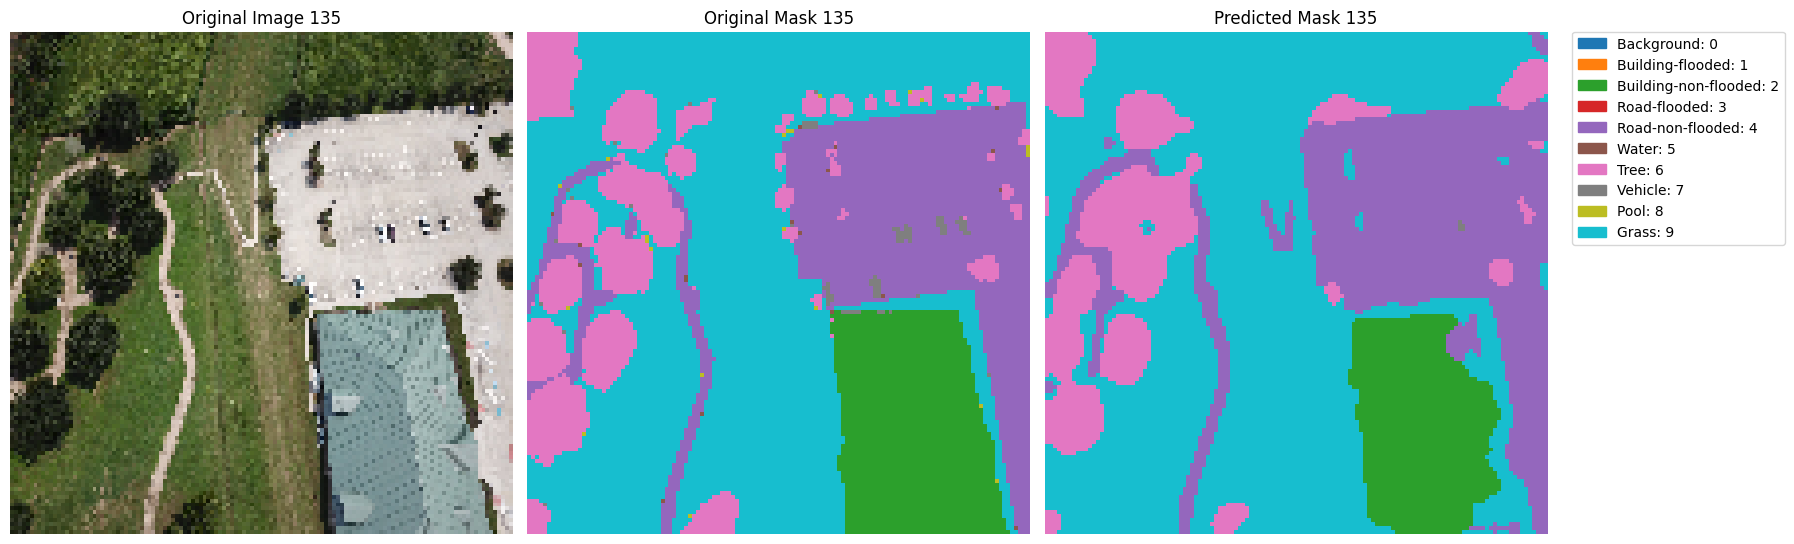

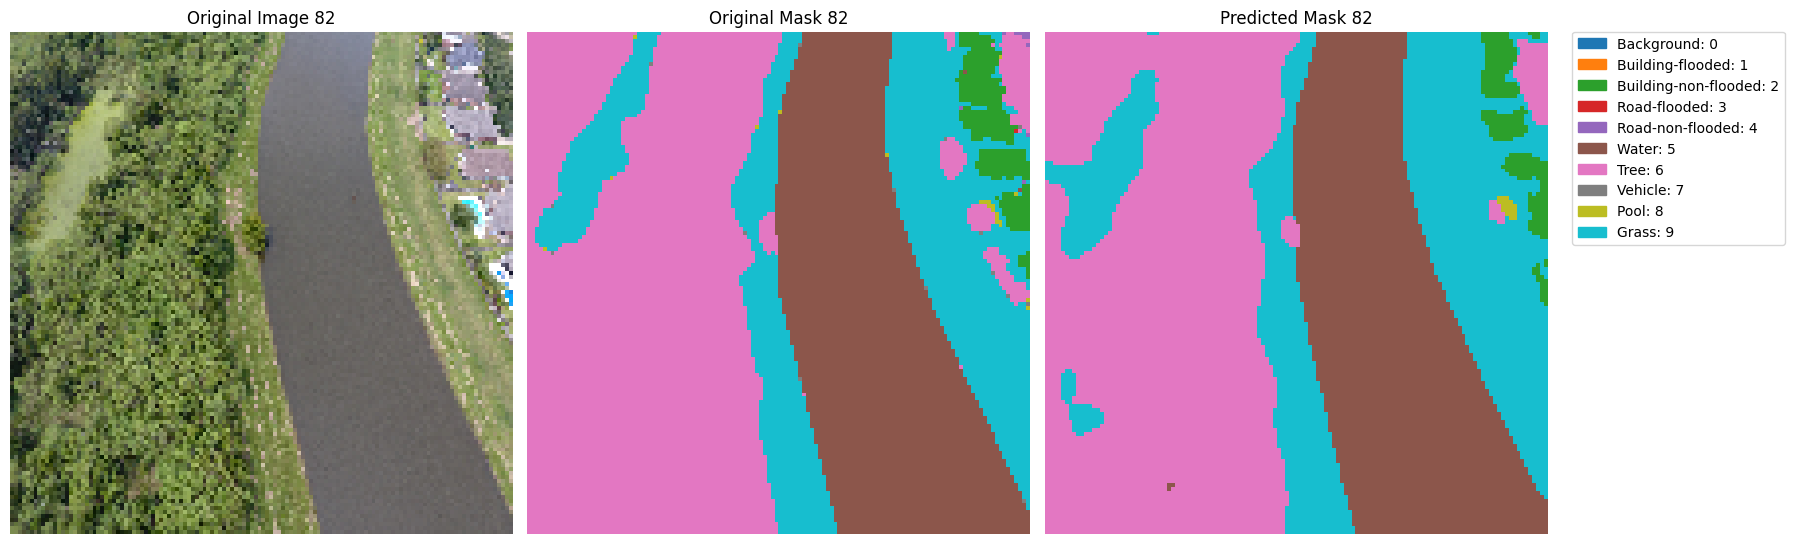

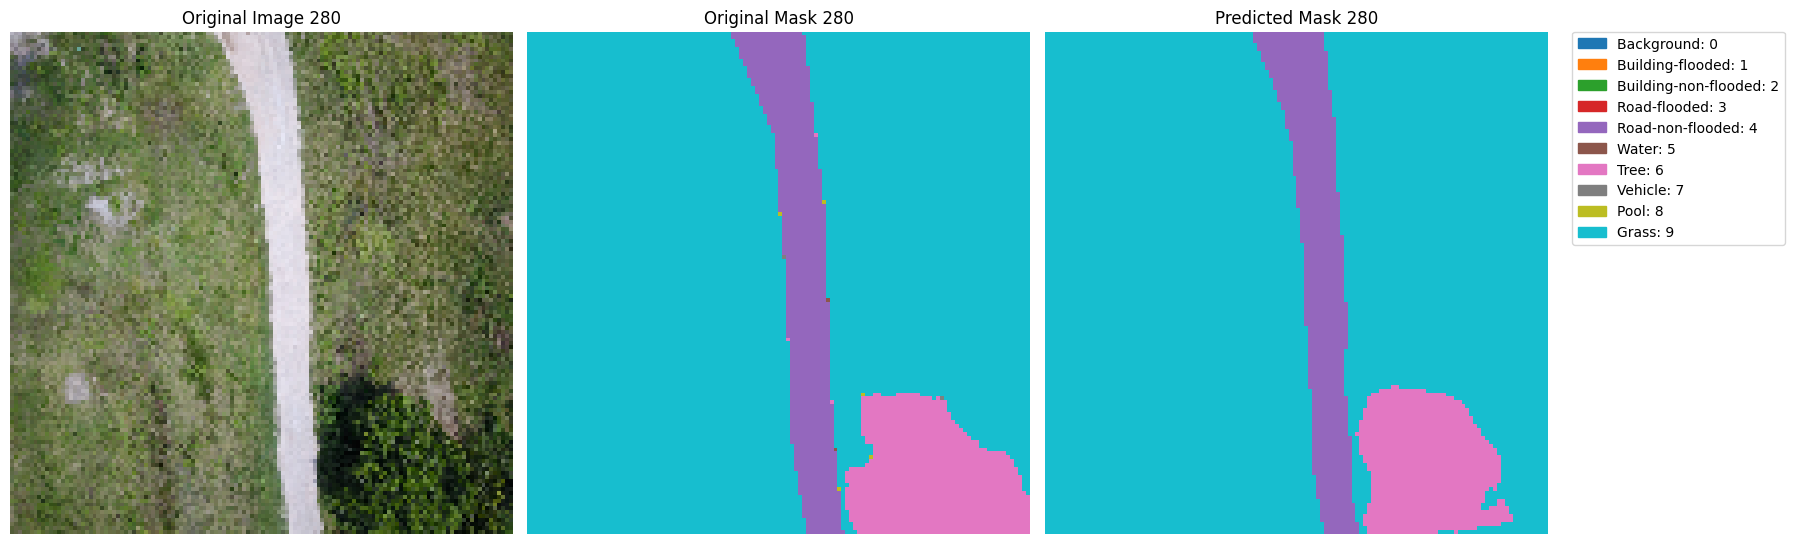

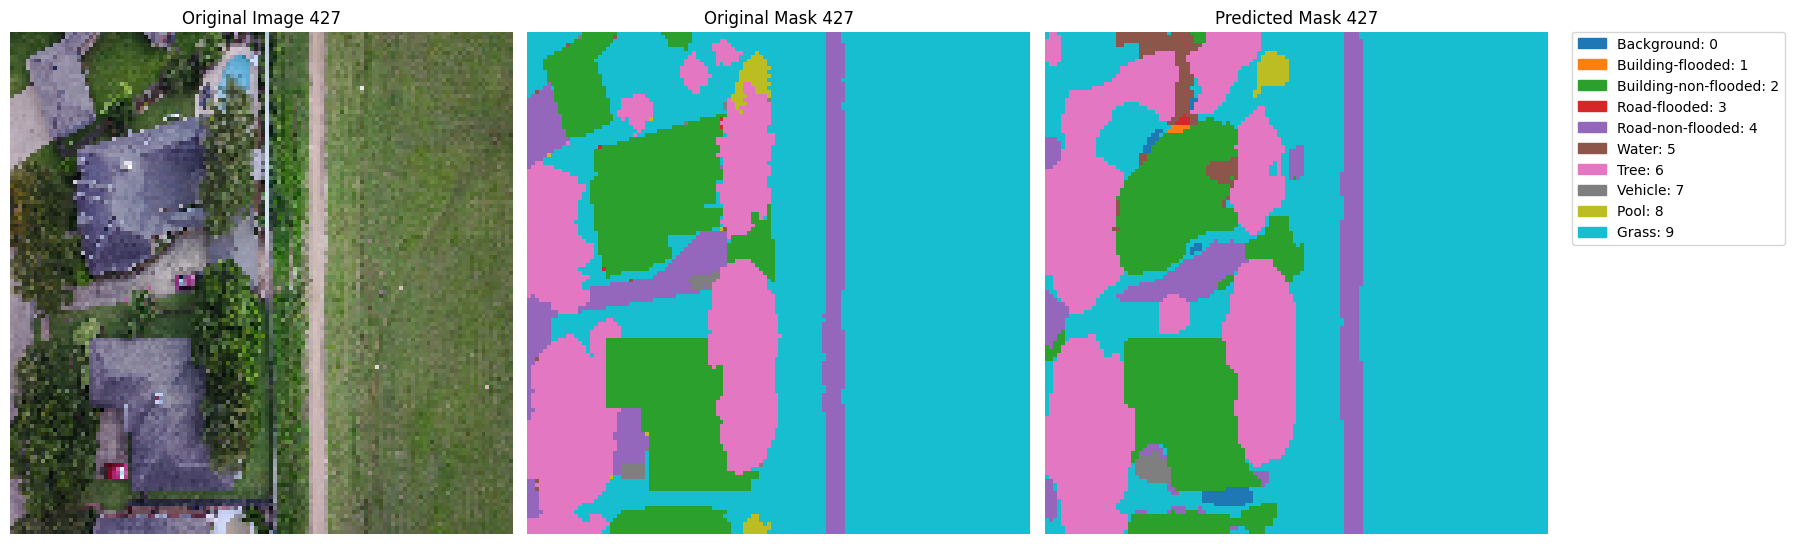

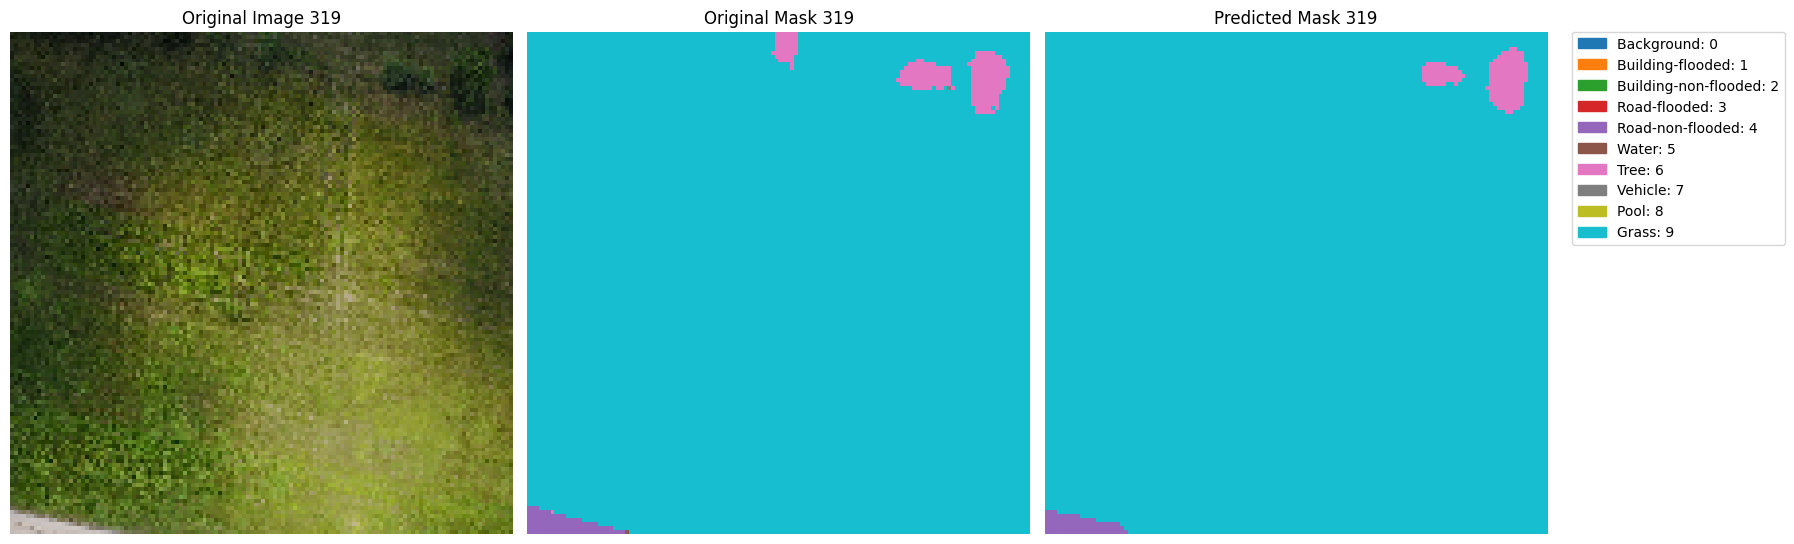

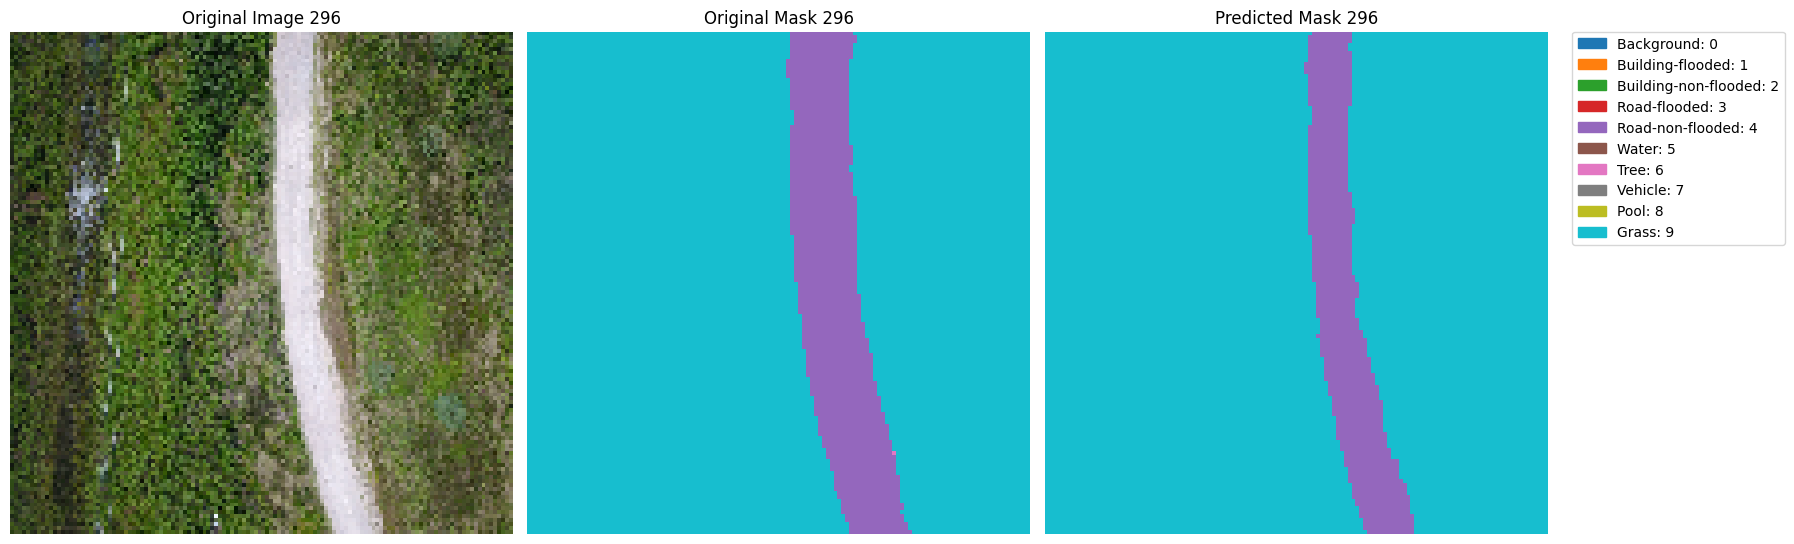

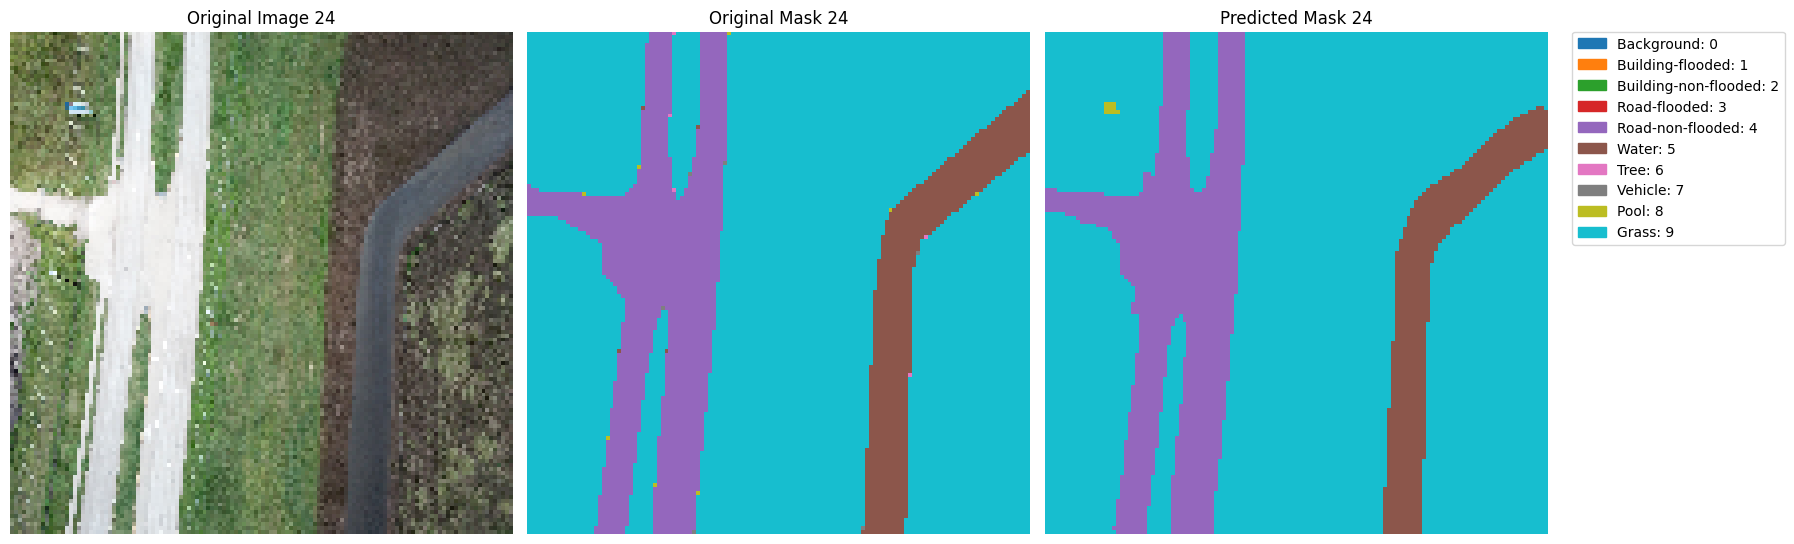

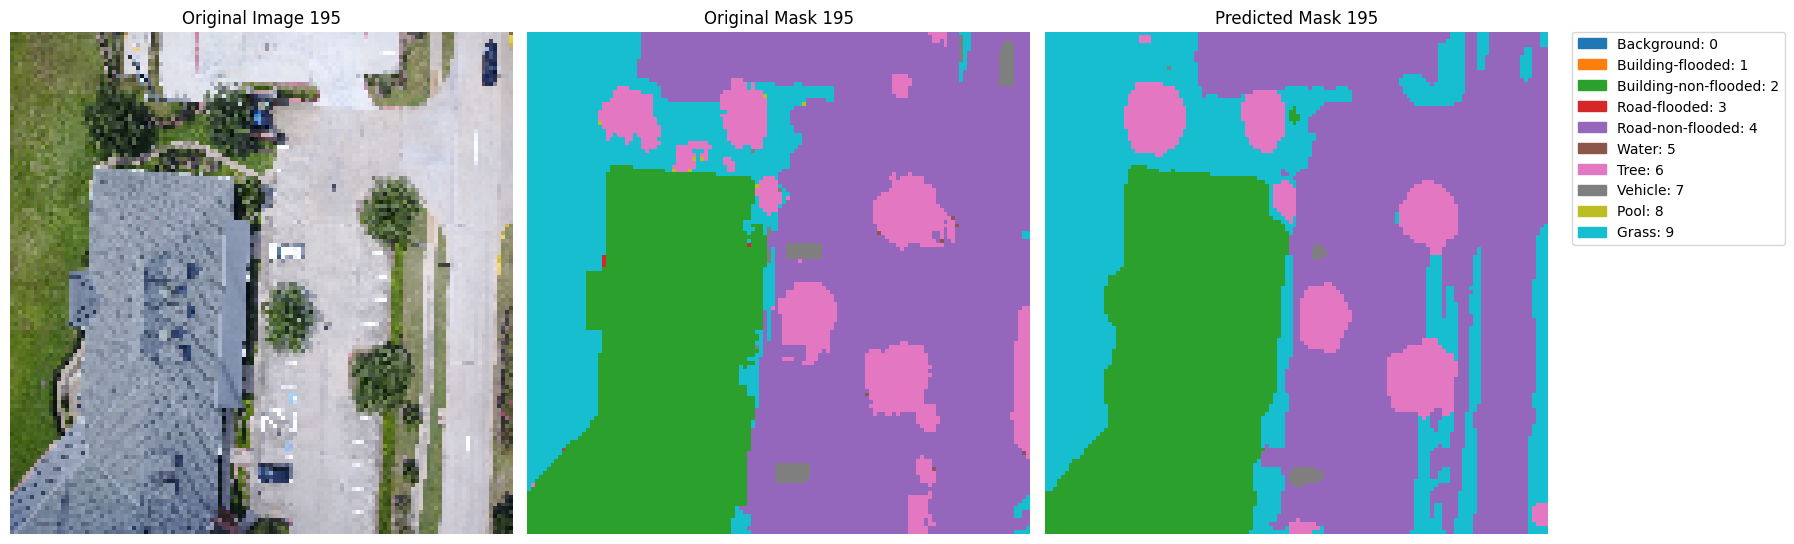

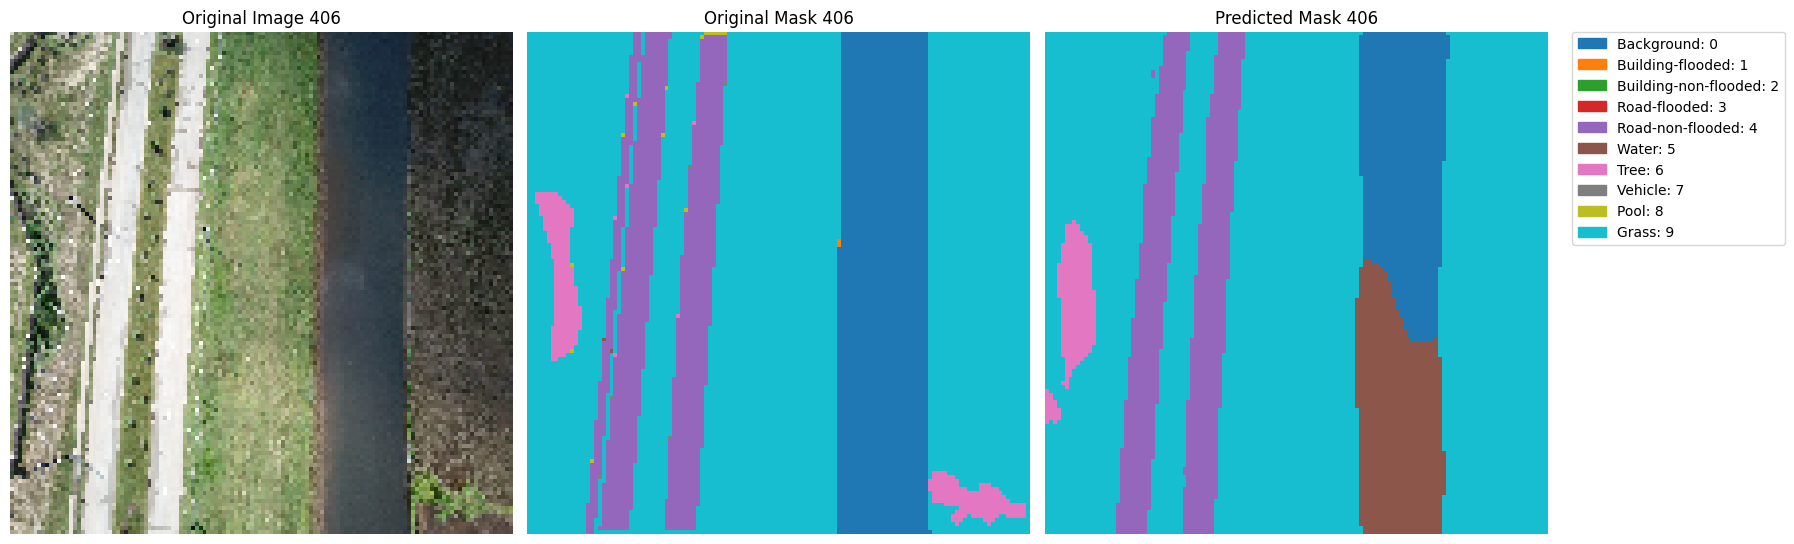

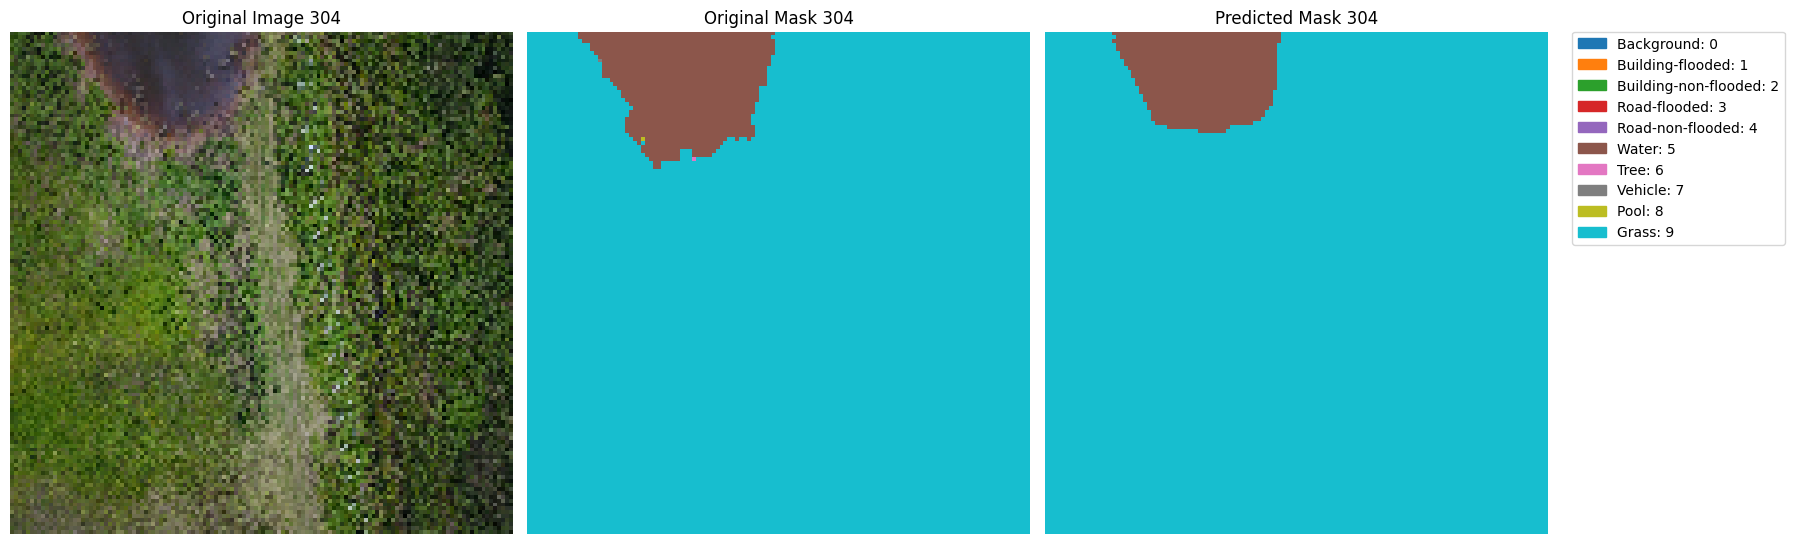

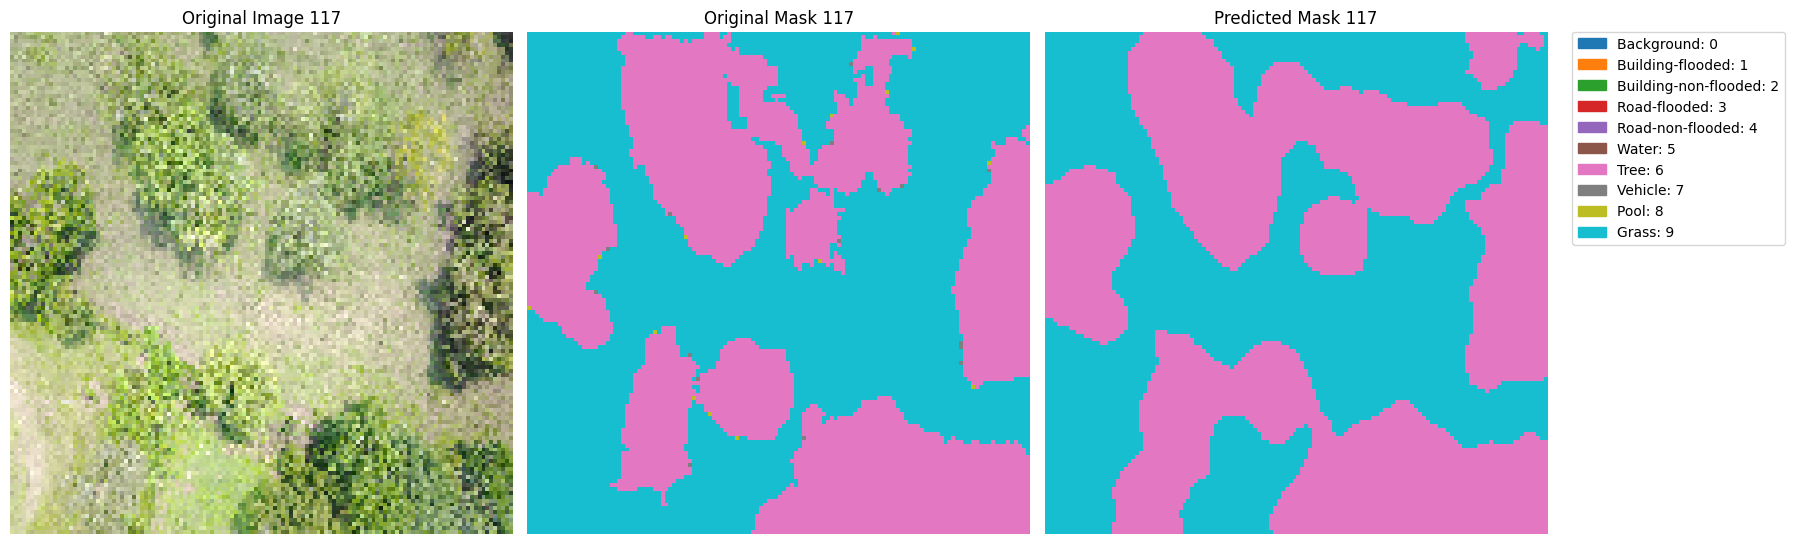

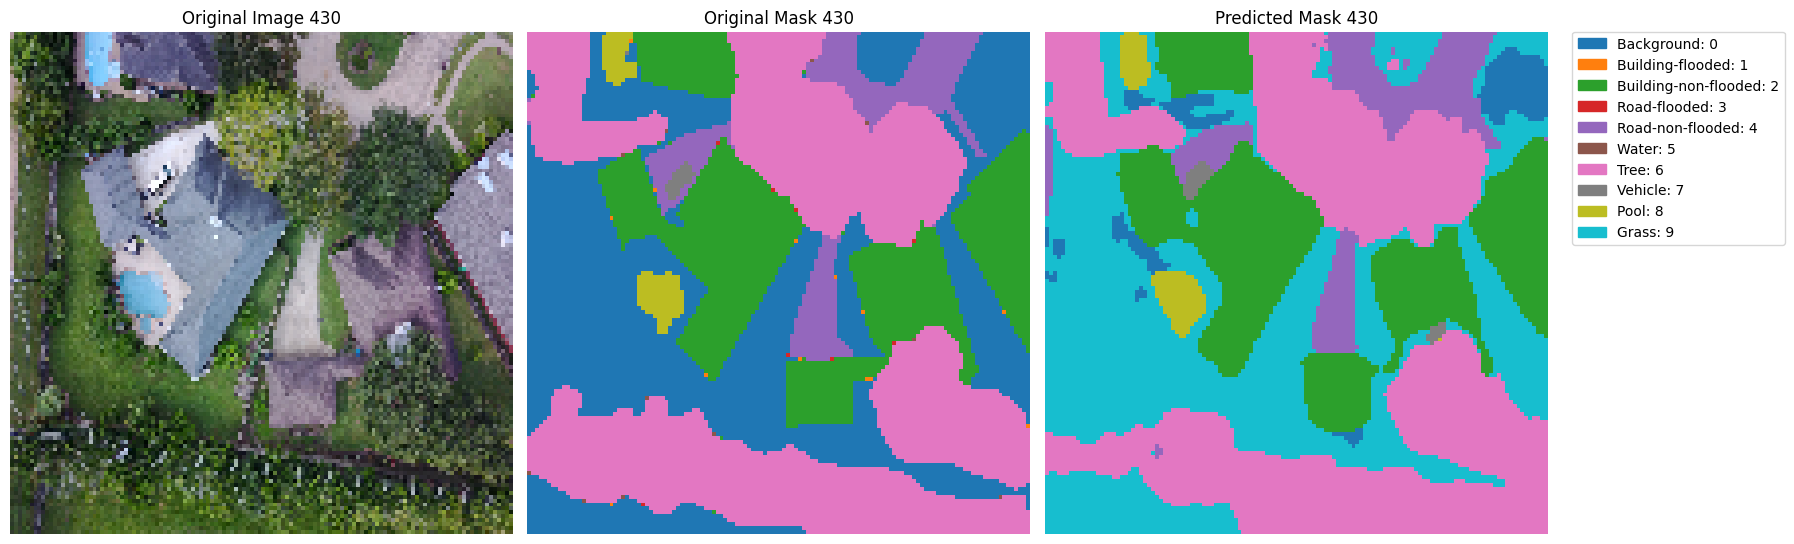

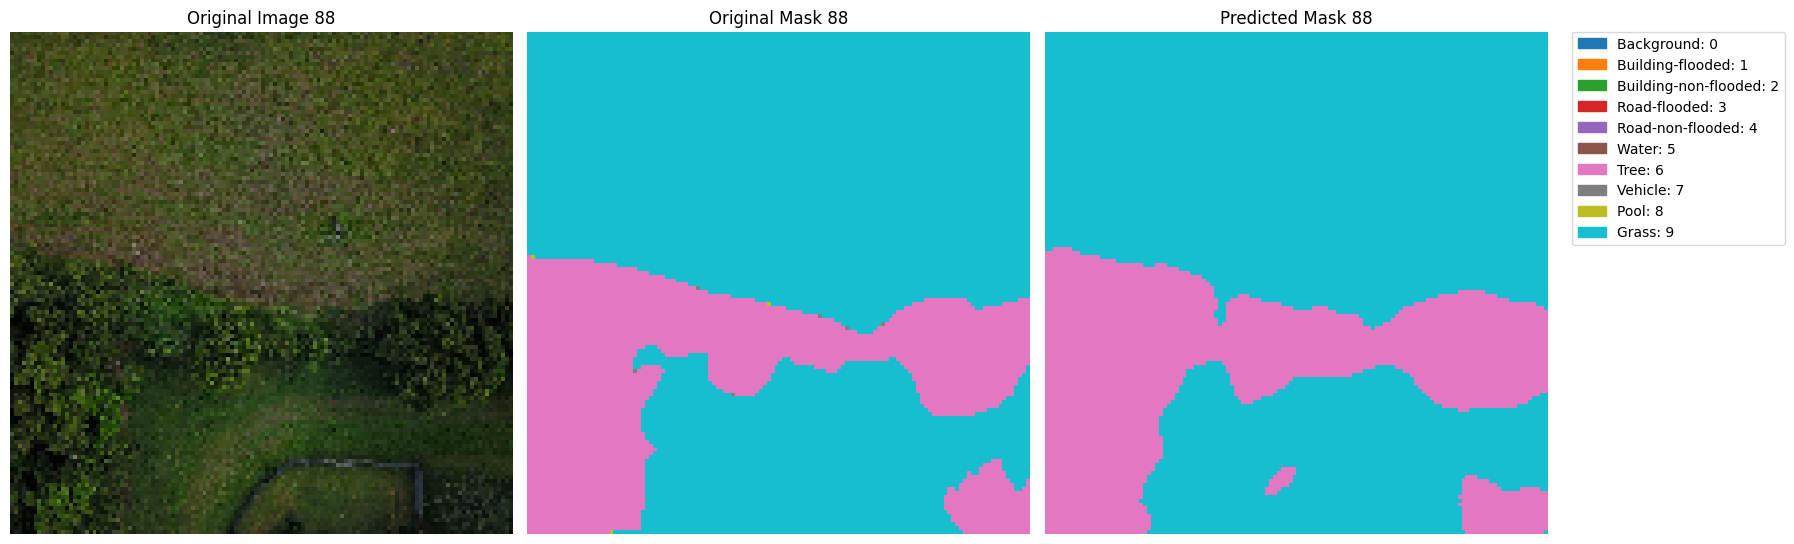

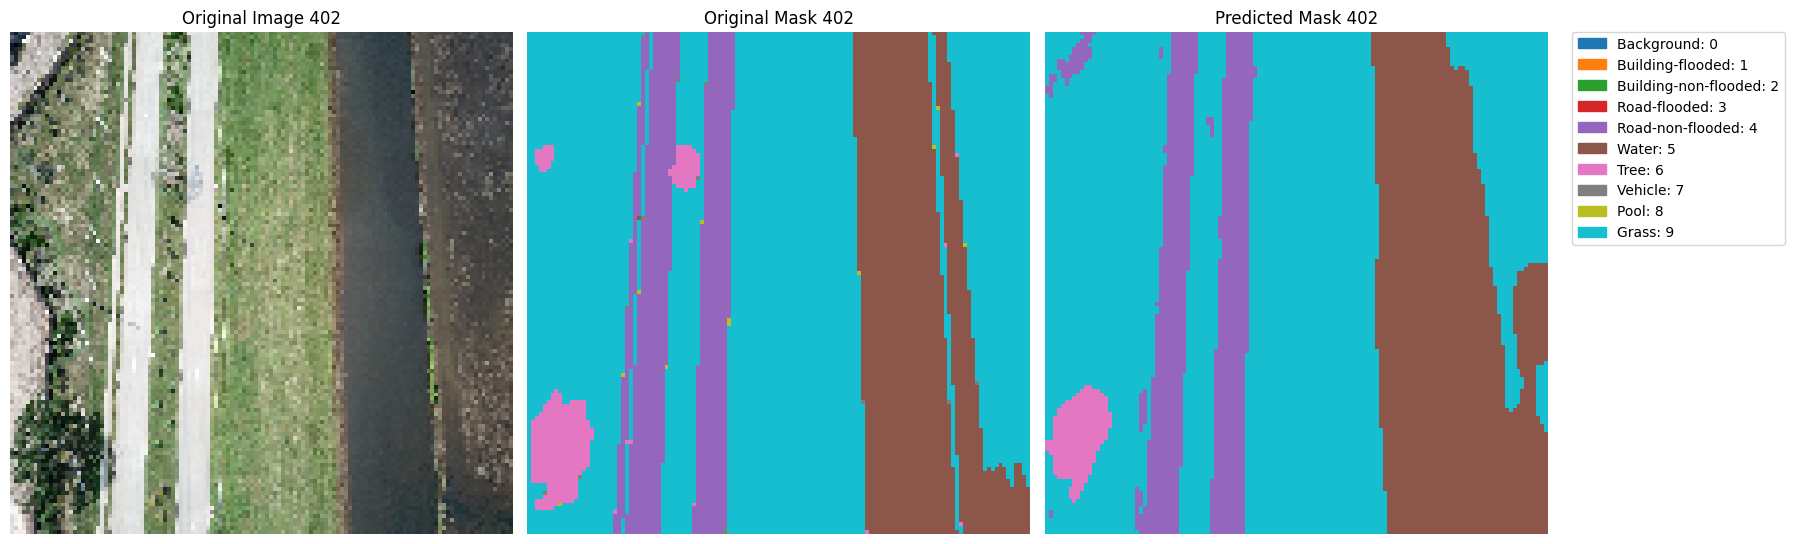

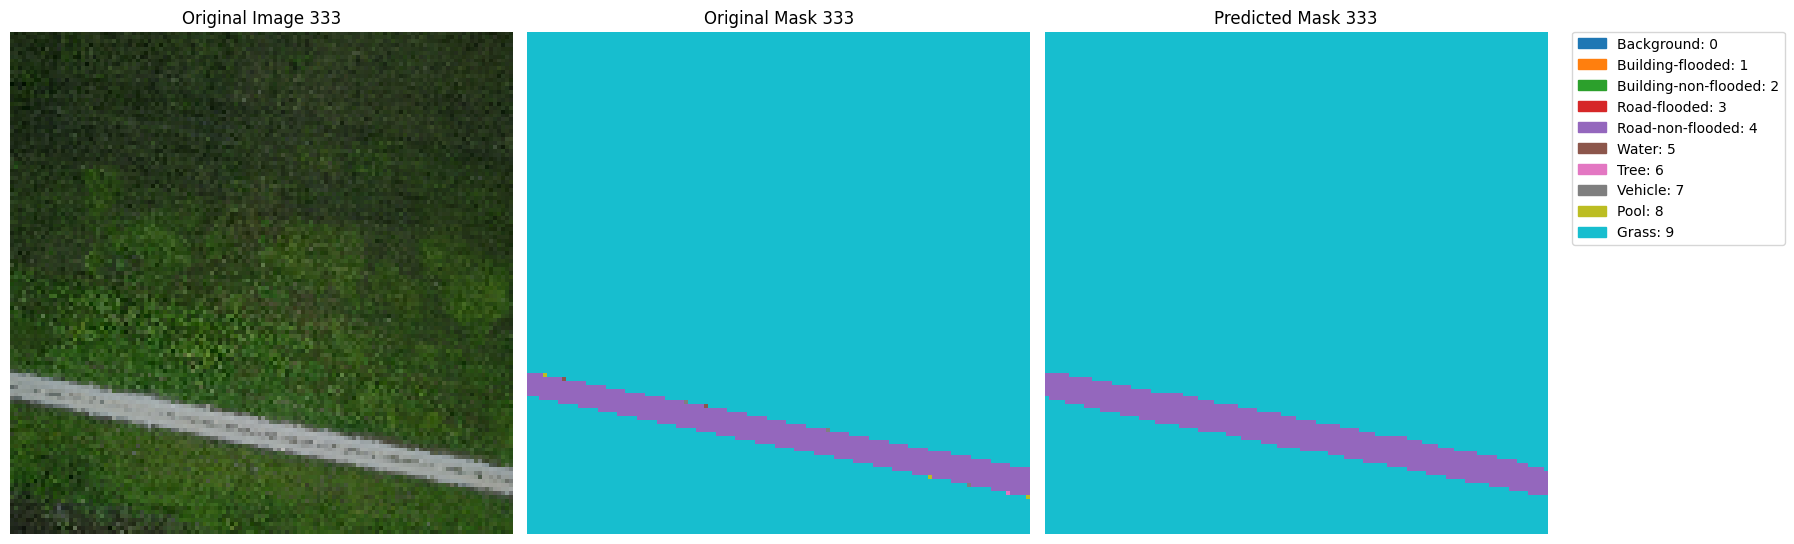

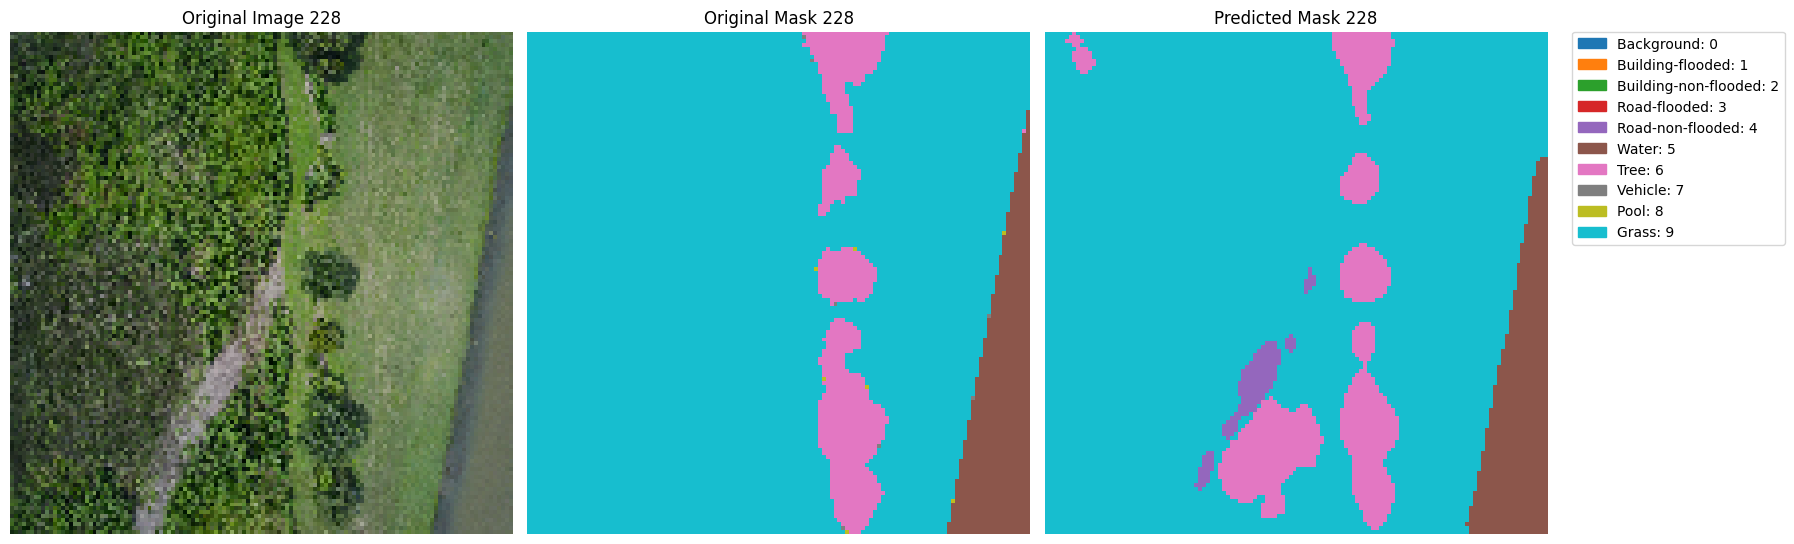

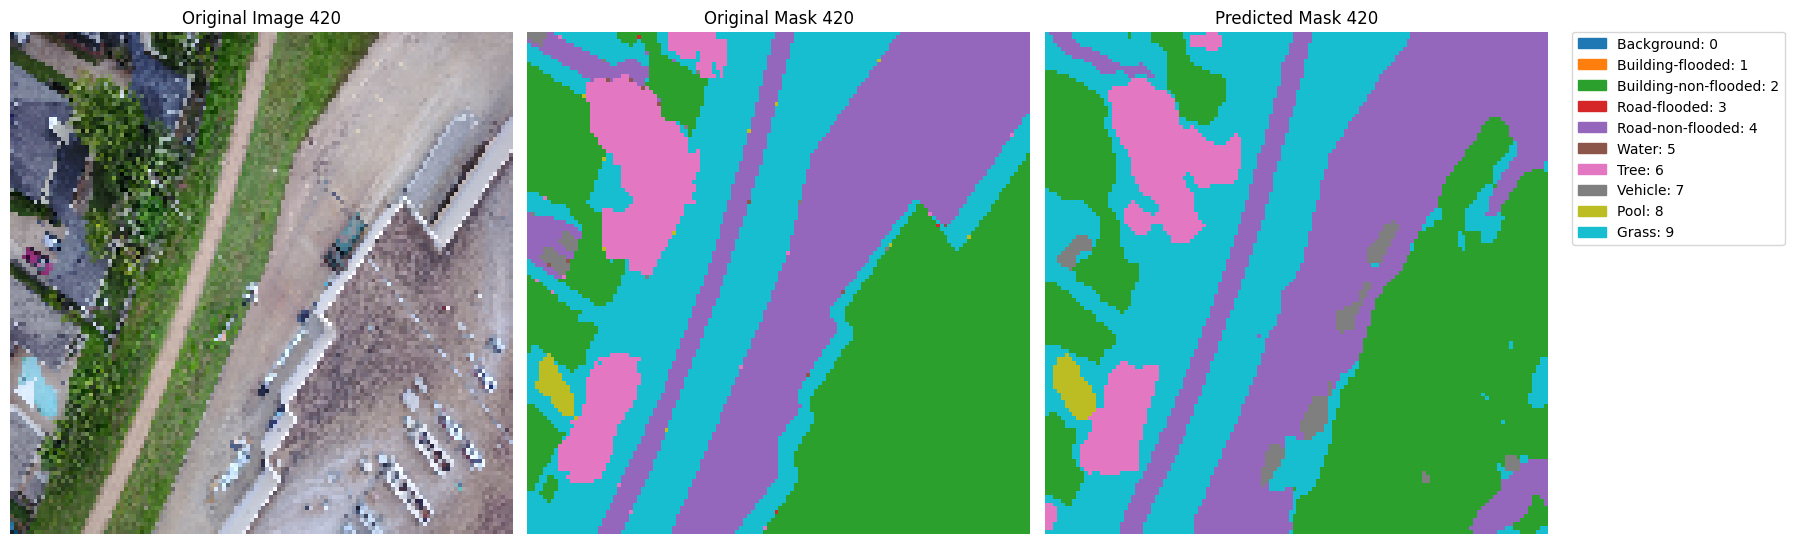

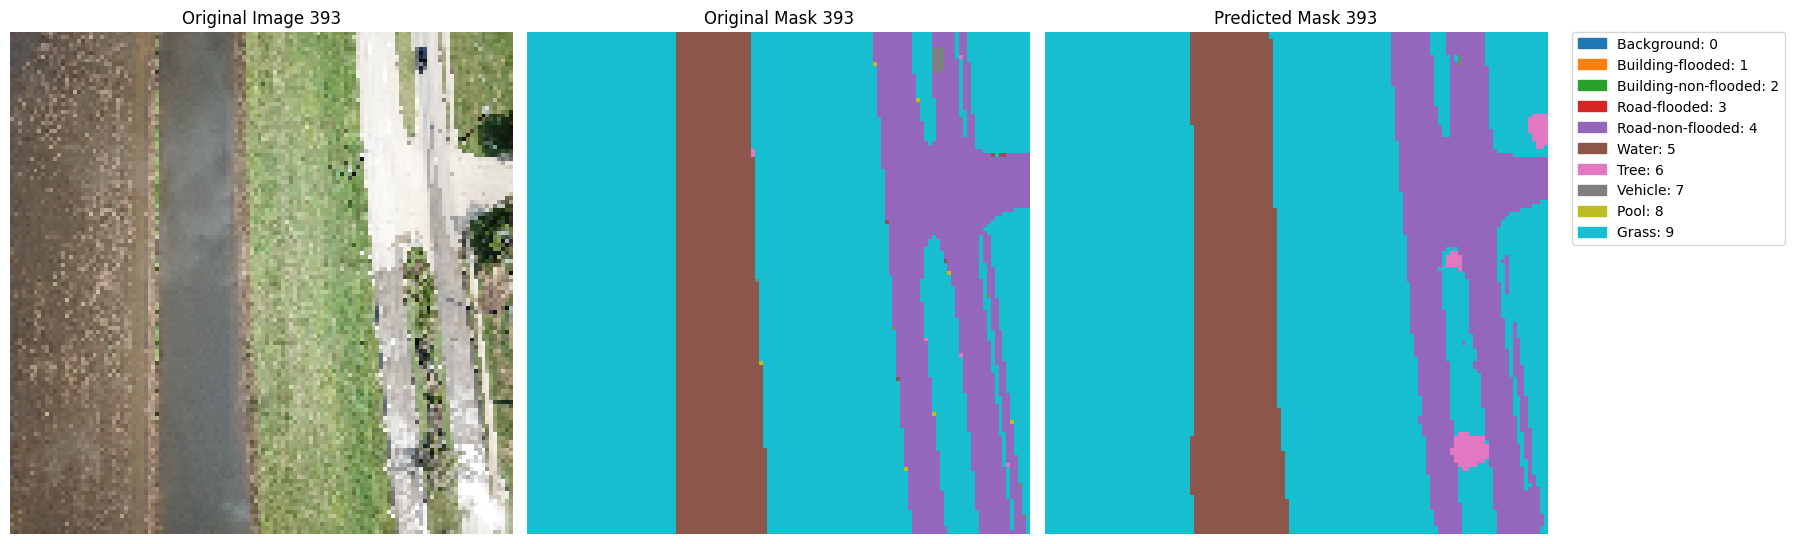

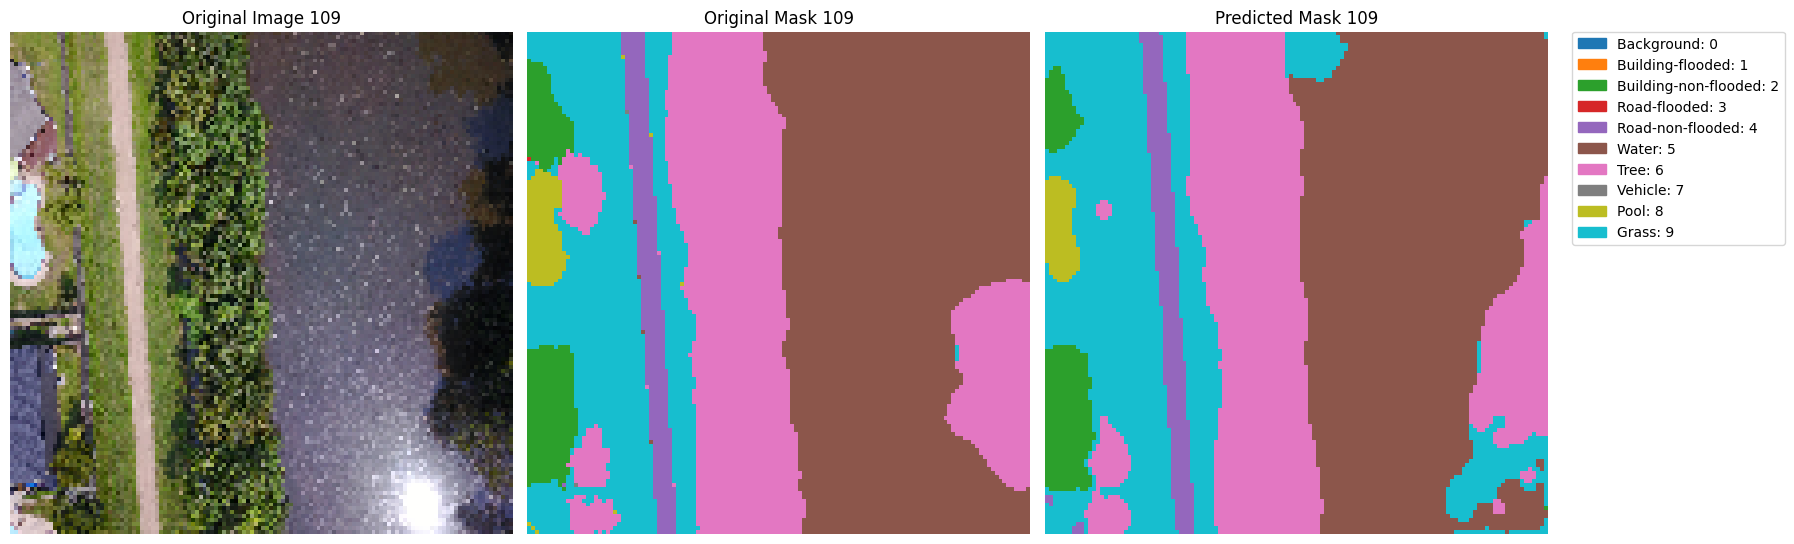

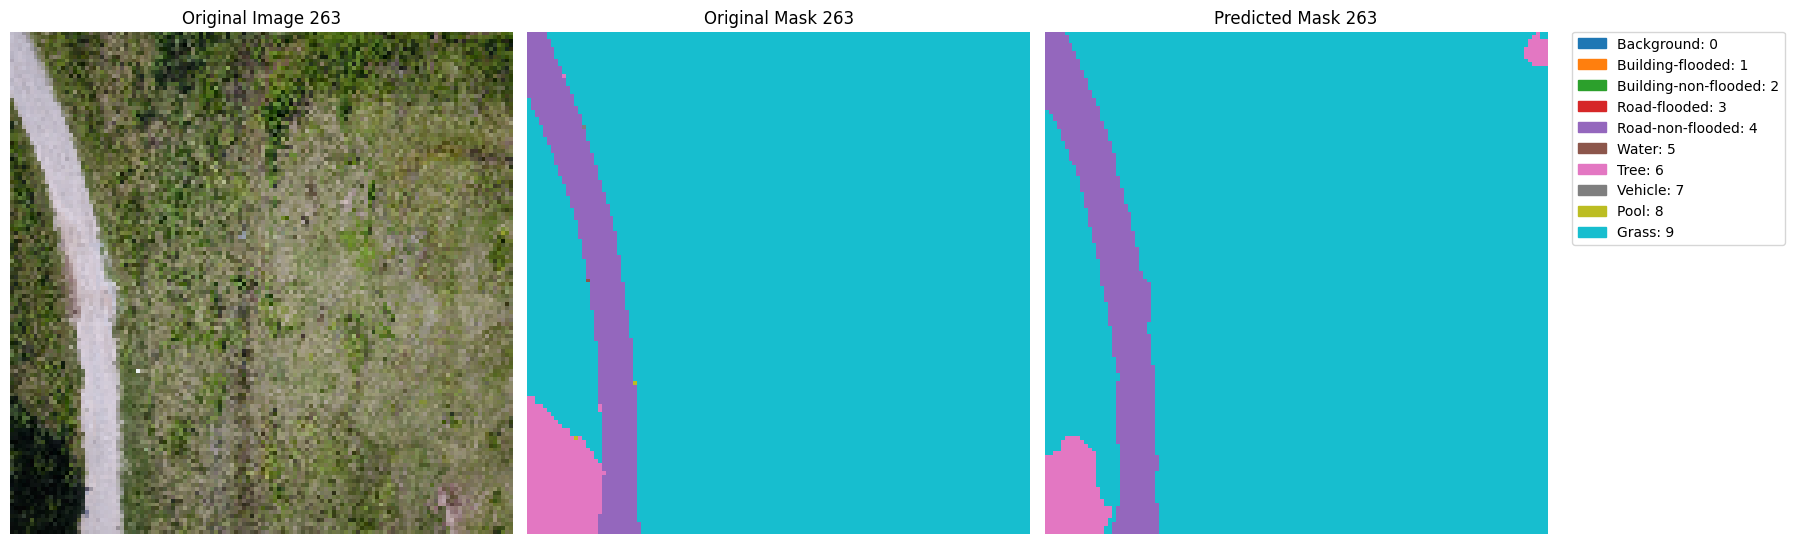

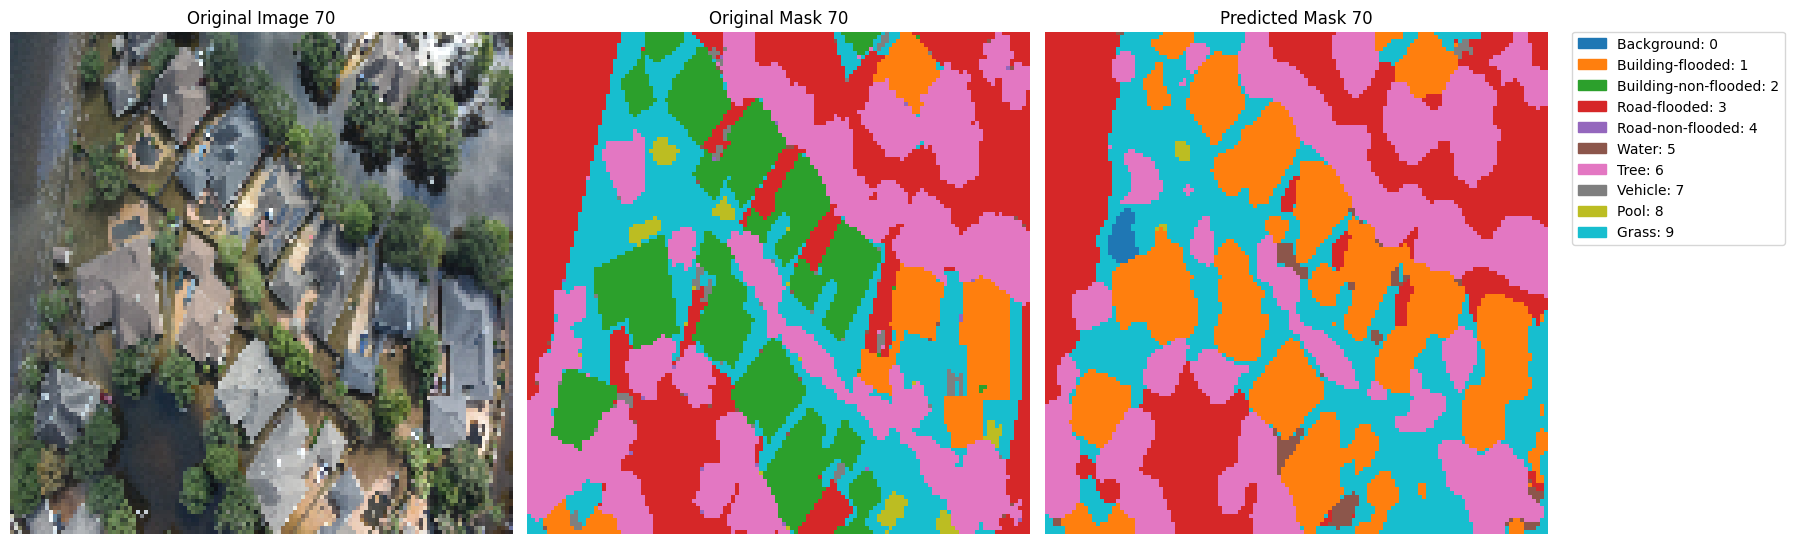

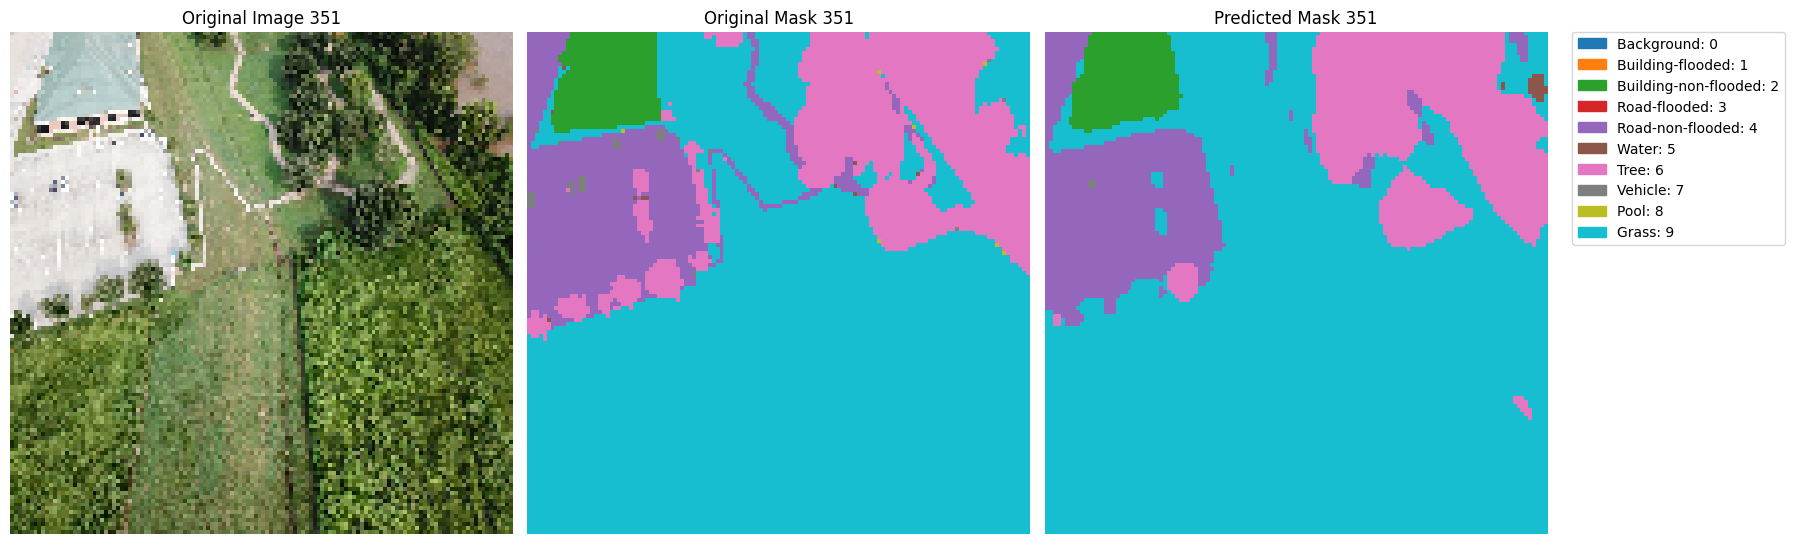

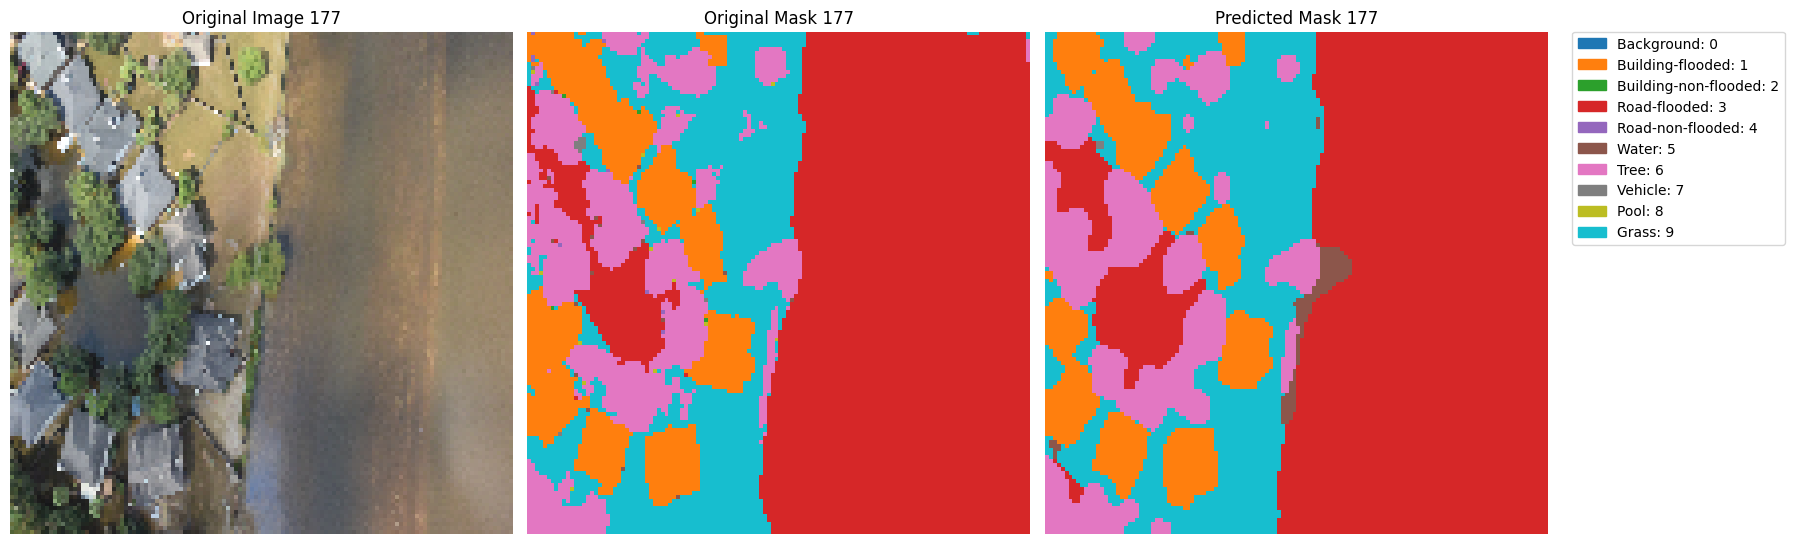

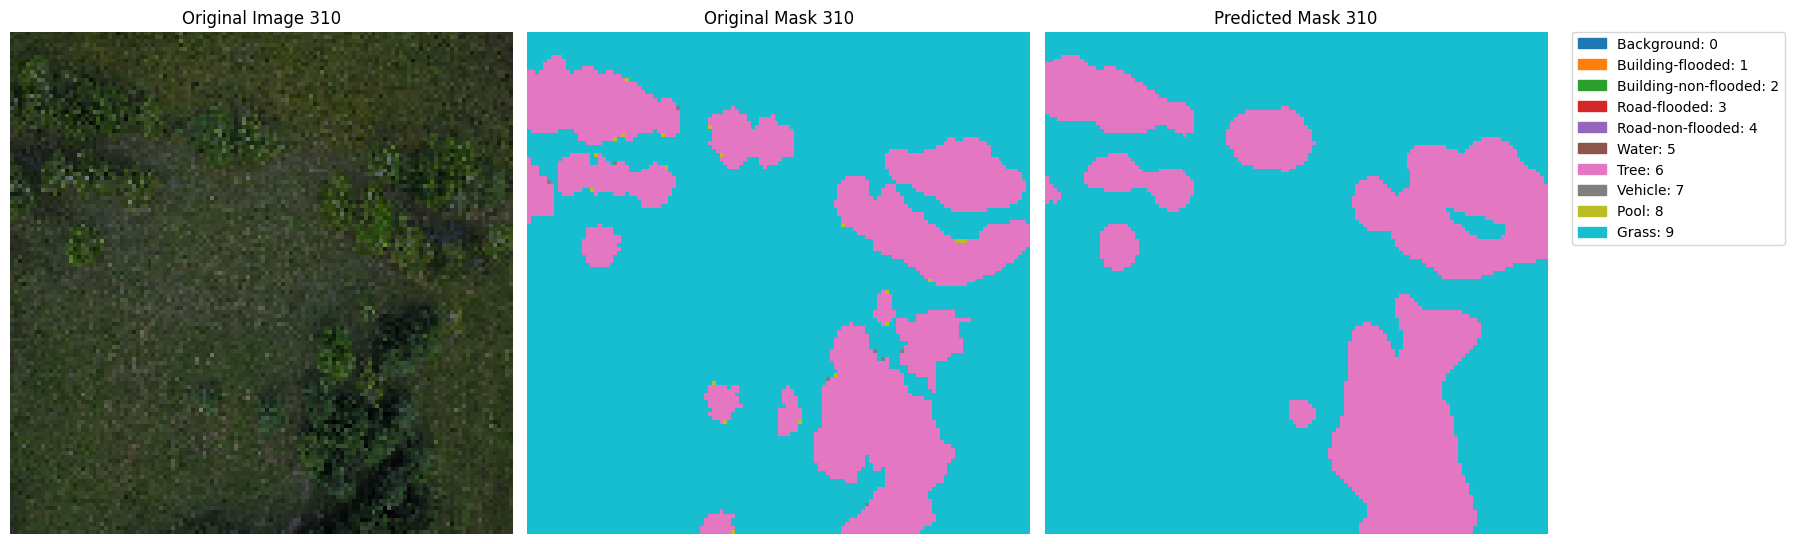

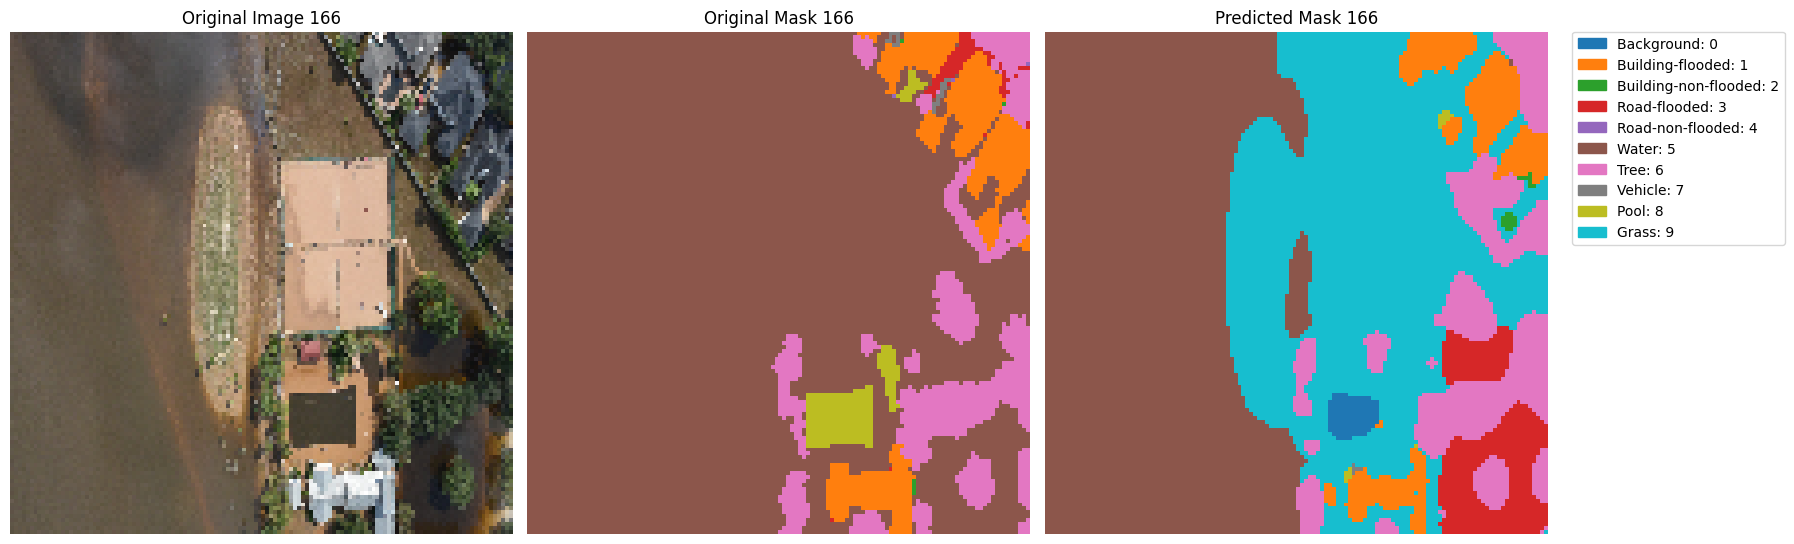

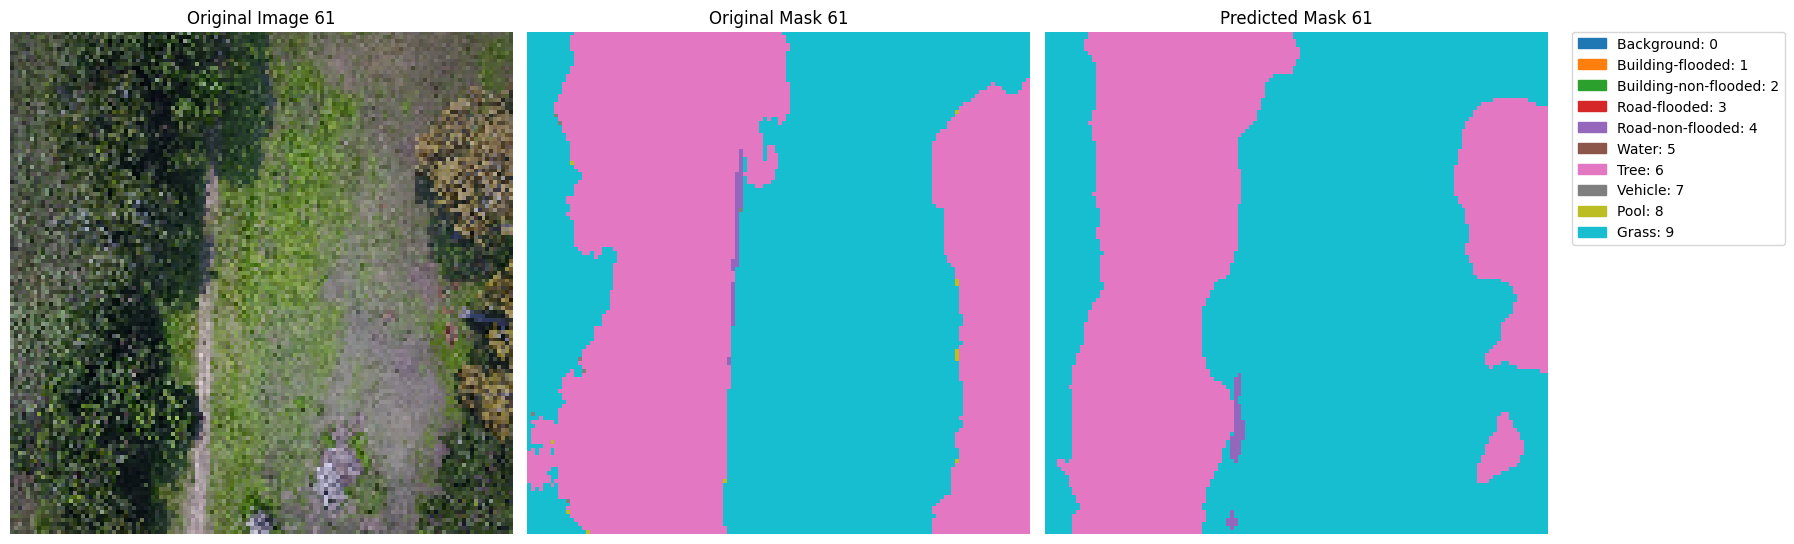

In [ ]:
# Visualize predictions along with original images and original masks
num_random_samples = 30
indices = np.random.choice(range(len(test_images)), num_random_samples, replace=False)
cmap = plt.cm.get_cmap('tab10', N_CLASSES)  # Ensure your N_CLASSES fits the 'tab10' or choose an appropriate colormap
legend_handles = [mpatches.Patch(color=cmap(i), label=f'{class_names[i]}: {i}') for i in range(N_CLASSES)]

for i in indices:
    plt.figure(figsize=(18, 6))  # Adjusted figure size to accommodate three subplots

    # Original Image
    plt.subplot(1, 3, 1)
    plt.imshow(test_images[i])
    plt.title(f"Original Image {i+1}")
    plt.axis('off')  # Optional: Remove axis for cleaner visualization

    # Original Mask
    plt.subplot(1, 3, 2)
    original_mask = np.argmax(test_masks[i], axis=-1)  # Assuming test_masks is one-hot encoded
    plt.imshow(original_mask, cmap=cmap, vmin=0, vmax=N_CLASSES-1)
    plt.title(f"Original Mask {i+1}")
    plt.axis('off')  # Optional: Remove axis for cleaner visualization

    # Predicted Mask
    plt.subplot(1, 3, 3)
    plt.imshow(test_predictions_argmax[i], cmap=cmap, vmin=0, vmax=N_CLASSES-1)
    plt.title(f"Predicted Mask {i+1}")
    plt.legend(handles=legend_handles, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    plt.axis('off')  # Optional: Remove axis for cleaner visualization

    plt.tight_layout()
    plt.show()
